In [2]:
from typing import Optional

import numpy as np

from PIL import Image
from torchvision import transforms
import albumentations as albu
import cv2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set()

In [3]:
print(f'albumentations: {albu.__version__}')
print(f'cv2: {cv2.__version__}')

albumentations: 0.4.3
cv2: 4.2.0


In [4]:
def display_and_save_image(image: Image, name: str, titlesize: int=12):    
    # Display image with the right DPI setting
    dpi = float(mpl.rcParams['figure.dpi'])

    w, h = image.size
    size = w / dpi, h / dpi

    fig = plt.figure(figsize=size)

    title_y = 1 + 0.3 / size[1]
    fig.suptitle(name, fontsize=titlesize, y=title_y, weight='bold')
    ax = fig.add_axes([0, 0, 1, 1])

    ax.axis('off')
    ax.imshow(image)
    plt.show()
    
    # Save image
    image.save(f'../data/{name}.png', format='PNG')

Size: (1200, 800)


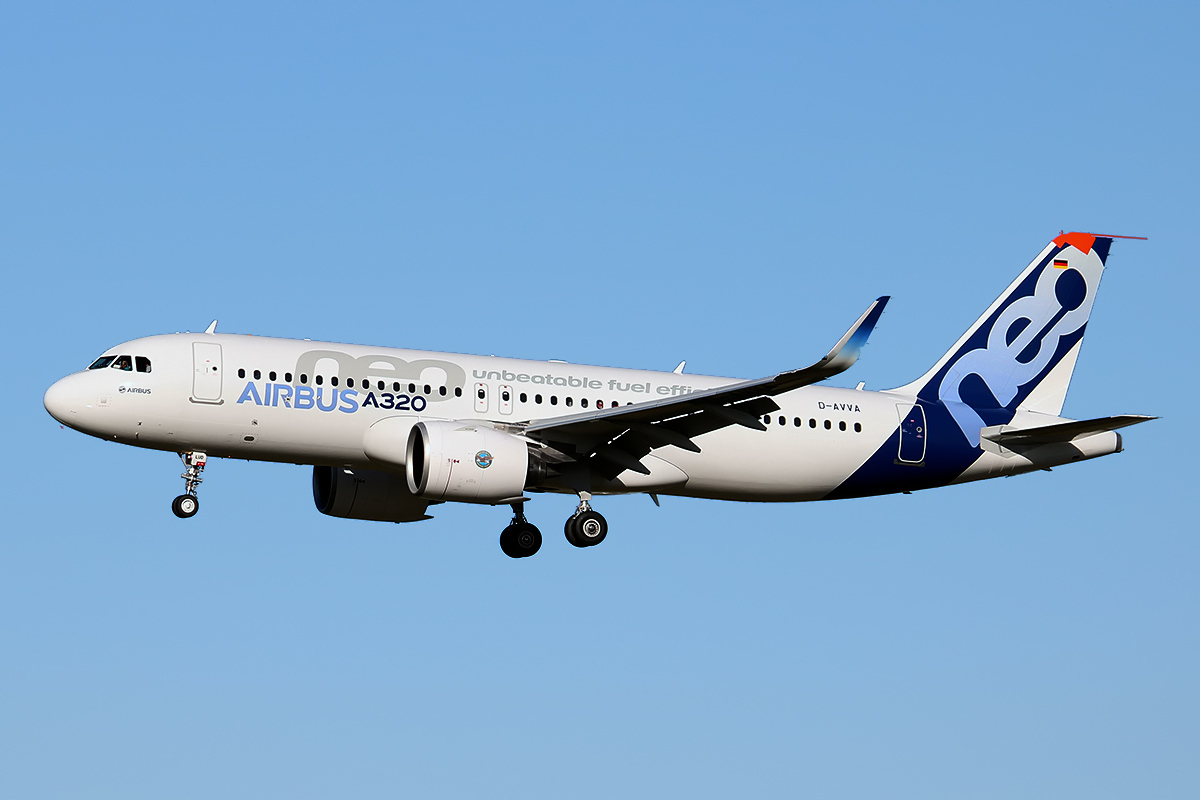

In [5]:
# photo taken by Pedro Aragão 
# see https://commons.wikimedia.org/wiki/File:Airbus_A320-271N_NEO_D-AVVA.jpg

image = Image.open('../data/a320.jpg')
w, h = image.size

print(f'Size: {image.size}')
image

In [6]:
scale = 0.2
new_h = int(h * scale)
new_w = int(w * scale)

def resize_albu(image, interpolation):
    aug = albu.Resize(new_h, new_w, interpolation=interpolation)

    image_arr = np.array(image)
    aug_arr = aug(image=image_arr)
    return Image.fromarray(aug_arr['image'])


def resize_torchvision(image, interpolation):
    aug = transforms.Resize((new_h, new_w), interpolation=interpolation)
    return aug(image)

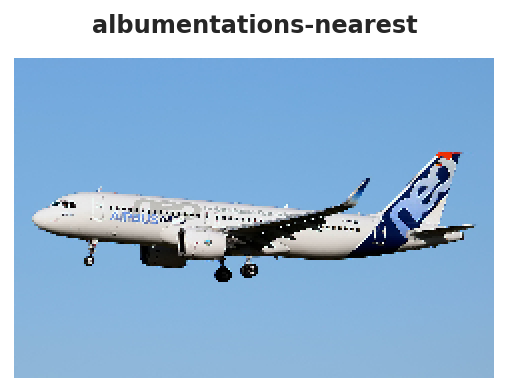

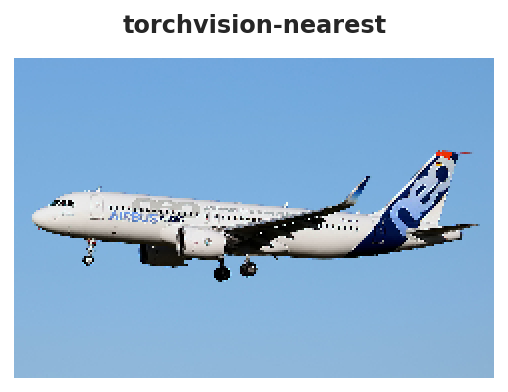

In [7]:
display_and_save_image(resize_albu(image, interpolation=cv2.INTER_NEAREST), name='albumentations-nearest')
display_and_save_image(resize_torchvision(image, interpolation=Image.NEAREST), name='torchvision-nearest')

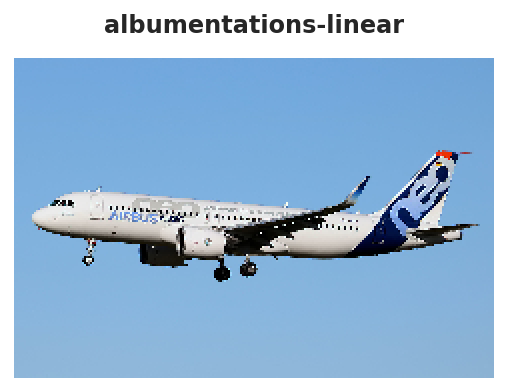

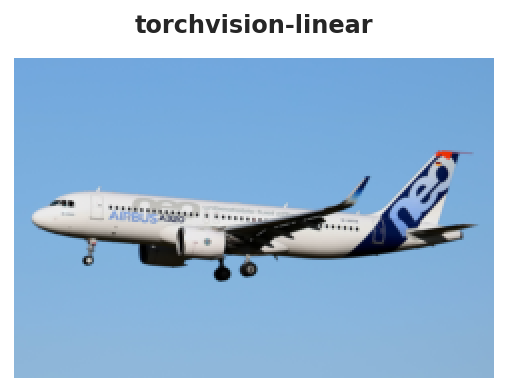

In [8]:
display_and_save_image(resize_albu(image, interpolation=cv2.INTER_LINEAR), name='albumentations-linear')
display_and_save_image(resize_torchvision(image, interpolation=Image.LINEAR), name='torchvision-linear')

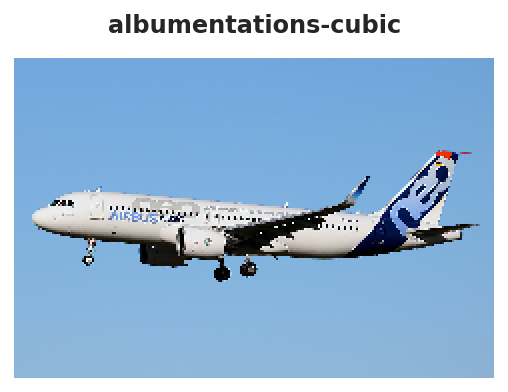

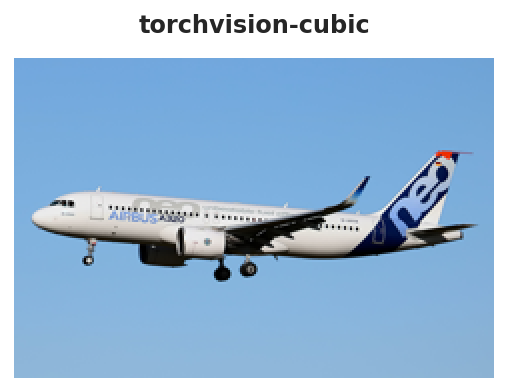

In [9]:
display_and_save_image(resize_albu(image, interpolation=cv2.INTER_CUBIC), name='albumentations-cubic')
display_and_save_image(resize_torchvision(image, interpolation=Image.CUBIC), name='torchvision-cubic')

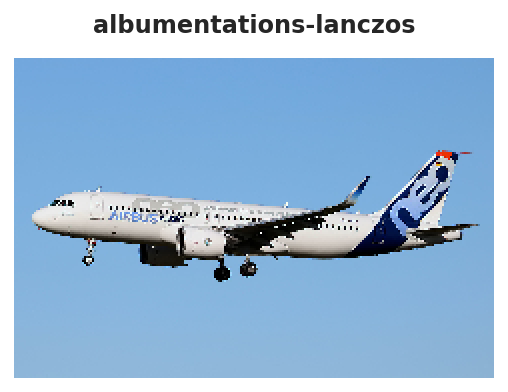

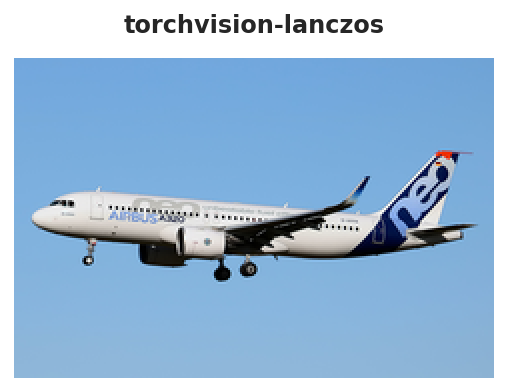

In [10]:
display_and_save_image(resize_albu(image, interpolation=cv2.INTER_LANCZOS4), name='albumentations-lanczos')
display_and_save_image(resize_torchvision(image, interpolation=Image.LANCZOS), name='torchvision-lanczos')

## Misc

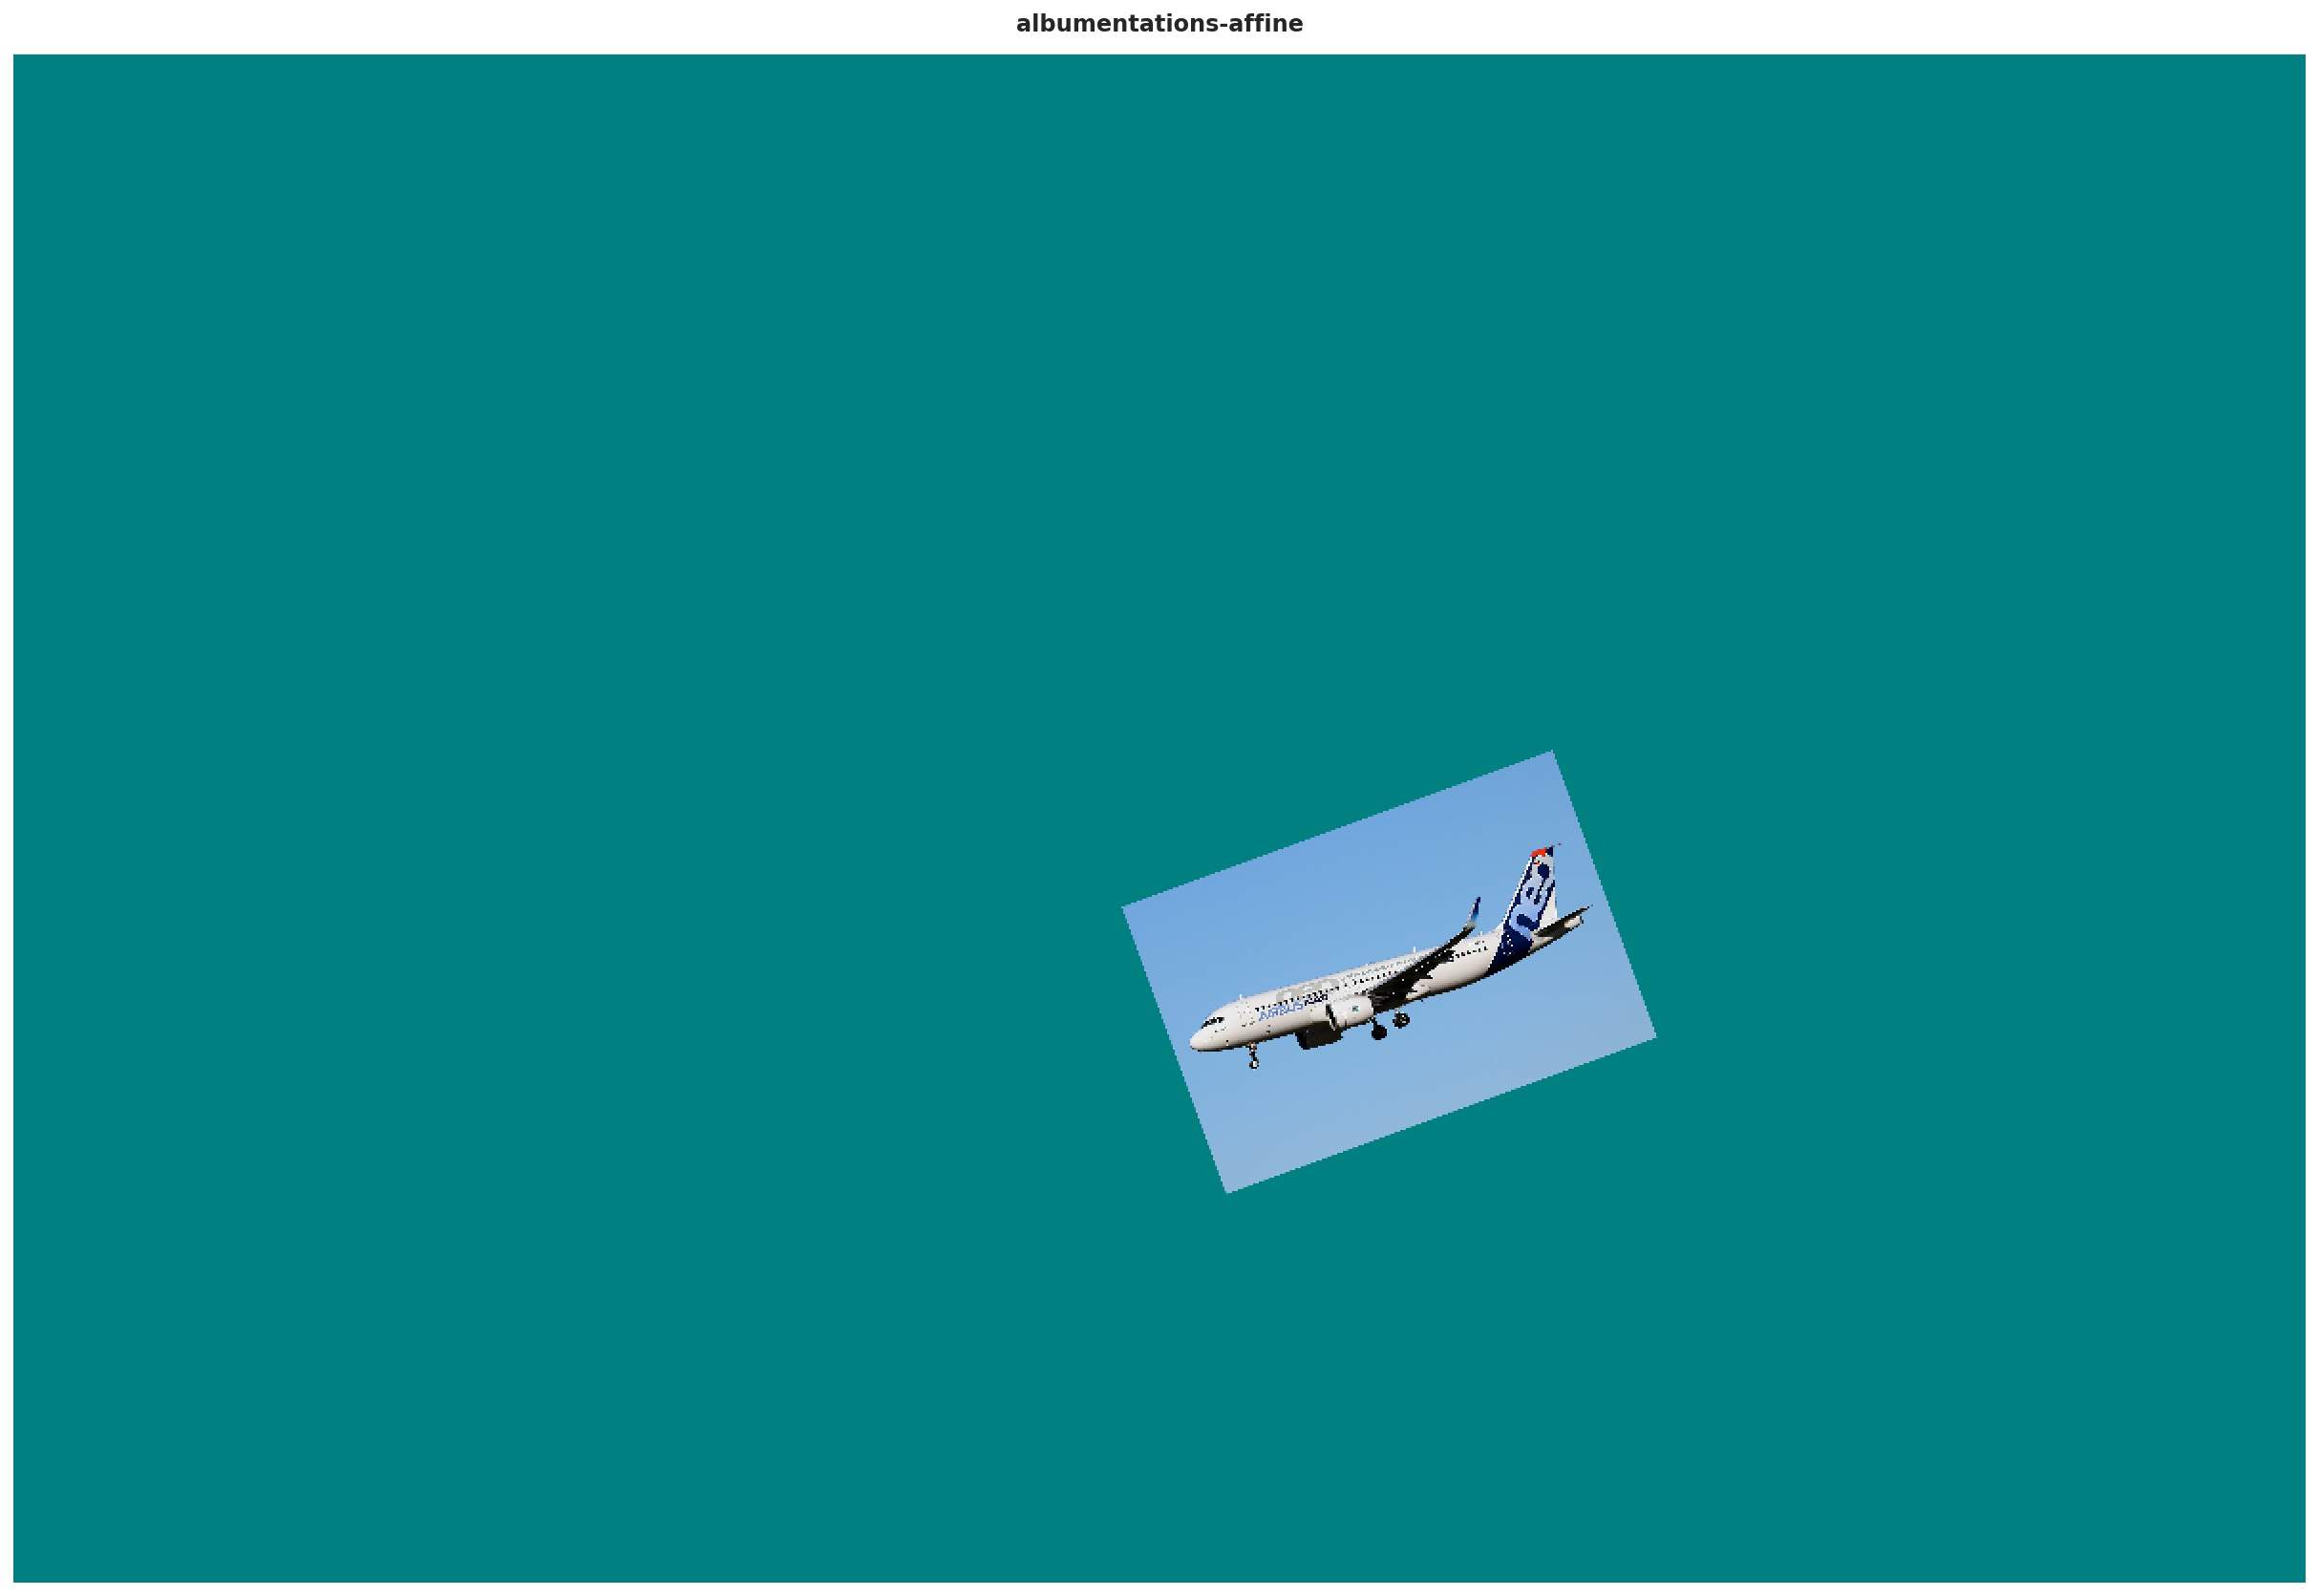

In [29]:
def affine_albu(image):
    aug = albu.ShiftScaleRotate(shift_limit=(0.1, 0.1),
                                scale_limit=(-0.8, -0.8),
                                rotate_limit=(20, 20),
                                border_mode=cv2.BORDER_CONSTANT,
                                value=(0, 128, 128),
                                interpolation=cv2.INTER_LANCZOS4,
                                p=1.0)

    image_arr = np.array(image)
    aug_arr = aug(image=image_arr)
    return Image.fromarray(aug_arr['image'])

display_and_save_image(affine_albu(image), name='albumentations-affine')

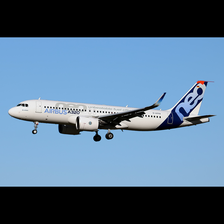

In [49]:
from numbers import Number
from typing import Union, Tuple

class SquarePaddedResize(object):
    def __init__(self, size: Union[Tuple[int, int], int], fill: Union[Number, str, tuple] = 0, interpolation: int = Image.BILINEAR):
        self.size = size
        self.fill = fill
        self.interpolation = interpolation

    def __call__(self, img: Image) -> Image:
        from torchvision.transforms import functional as F
        
        w, h = img.size
        if w != h:
            diff = max(w, h) - min(w, h)
            d1 = int(diff / 2)
            d2 = diff - d1

            padding = (0, d1, 0, d2) if w > h else (d1, 0, d2, 0)
            img = F.pad(img, padding, self.fill)

        return F.resize(img, self.size, self.interpolation)

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(size={self.size}, fill={self.fill}, interpolation={self.interpolation})'
    
resize = SquarePaddedResize(size=224, interpolation=Image.LANCZOS)
resize(image)